In [1]:
import numpy as np  # Importing NumPy for numerical operations and array manipulations

In [2]:
import matplotlib.pyplot as plt  # Importing Matplotlib for plotting graphs and visualizations

In [3]:
import seaborn as sns  # Importing Seaborn for statistical data visualization, built on top of Matplotlib

In [4]:
import tensorflow as tf  # Importing TensorFlow for building and training machine learning models

In [5]:
from tensorflow import keras  # Importing Keras, a high-level API for TensorFlow, to simplify model building

In [6]:
from tensorflow.keras import Layer  # Importing Layer class for creating custom layers in Keras

In [7]:
from tensorflow.keras.models import Sequential  # Importing Sequential model for building neural networks layer-by-layer

In [8]:
from tensorflow.keras.layers import Rescaling , GlobalAveragePooling2D

In [9]:
from tensorflow.keras import layers, optimizers, callbacks  # Importing various modules for layers, optimizers, and callbacks in Keras

In [10]:
from sklearn.utils.class_weight import compute_class_weight  # Importing function to compute class weights for imbalanced datasets

In [11]:
from tensorflow.keras.applications import EfficientNetV2B2  # Importing EfficientNetV2S model for transfer learning

In [12]:
from sklearn.metrics import confusion_matrix, classification_report  # Importing functions to evaluate model performance

In [13]:
import gradio as gr  # Importing Gradio for creating interactive web interfaces for machine learning models

In [14]:
dataset_dir = r"C:\Users\91799\Downloads\Project\TrashType_Image_Dataset"
image_size = (124, 124)
batch_size = 32
seed = 42

In [15]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    shuffle = True,
    image_size=image_size,
    batch_size=batch_size
)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.


In [16]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    shuffle = True,
    image_size=image_size,
    batch_size=batch_size
)
val_class= val_ds.class_names

Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [17]:
val_batches = tf.data.experimental.cardinality(val_ds)  
test_ds = val_ds.take(val_batches // 2)  
val_dat = val_ds.skip(val_batches // 2)  
test_ds_eval = test_ds.cache().prefetch(tf.data.AUTOTUNE) 

In [18]:
print(train_ds.class_names)
print(val_class)
print(len(train_ds.class_names))

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
6


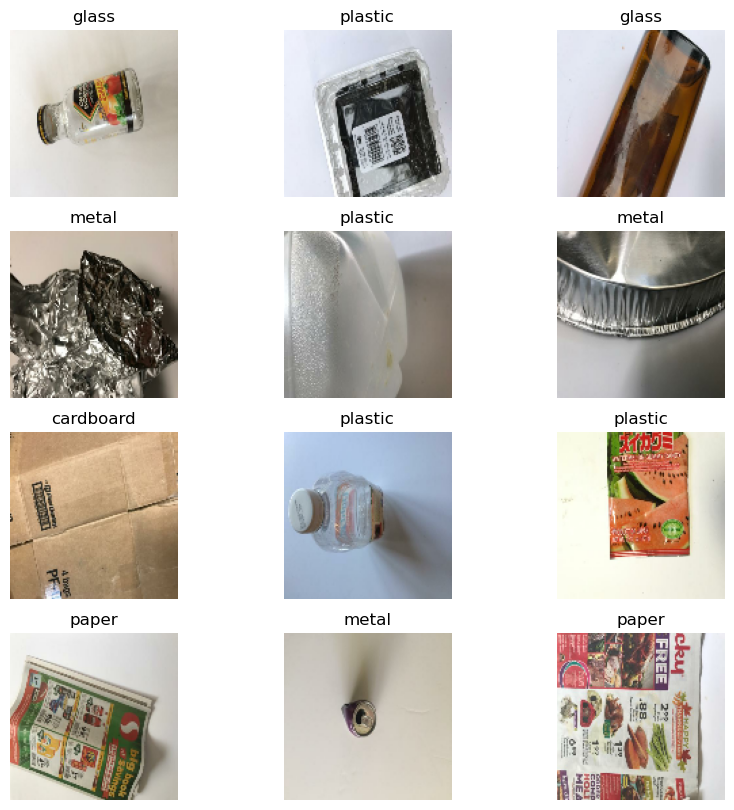

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

In [20]:
def count_distribution(dataset, class_names):
    total = 0
    counts = {name: 0 for name in class_names}
    
    for _, labels in dataset:
        for label in labels.numpy():
            class_name = class_names[label]
            counts[class_name] += 1
            total += 1

    for k in counts:
        counts[k] = round((counts[k] / total) * 100, 2)  # Convert to percentage
    return counts

In [21]:
def simple_bar_plot(dist, title):
    plt.bar(dist.keys(), dist.values(), color='cornflowerblue')
    plt.title(title)
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

In [22]:
class_names = train_ds.class_names

# Get class distributions
train_dist = count_distribution(train_ds, class_names)
val_dist = count_distribution(val_ds, class_names)
test_dist = count_distribution(test_ds, class_names)
overall_dist = {}
for k in class_names:
    overall_dist[k] = round((train_dist[k] + val_dist[k]) / 2, 2)

print(train_dist)
print(val_dist)
print(test_dist)
print(overall_dist)

{'cardboard': 16.52, 'glass': 19.73, 'metal': 15.92, 'paper': 23.29, 'plastic': 19.44, 'trash': 5.09}
{'cardboard': 13.66, 'glass': 20.2, 'metal': 17.43, 'paper': 24.36, 'plastic': 17.62, 'trash': 6.73}
{'cardboard': 14.06, 'glass': 17.58, 'metal': 16.8, 'paper': 25.0, 'plastic': 19.14, 'trash': 7.42}
{'cardboard': 15.09, 'glass': 19.96, 'metal': 16.68, 'paper': 23.82, 'plastic': 18.53, 'trash': 5.91}


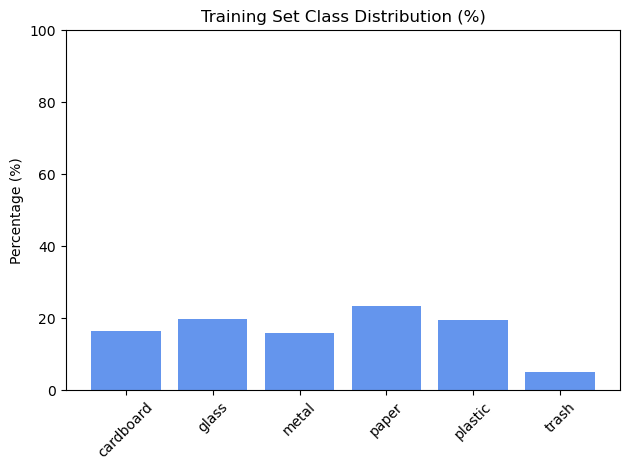

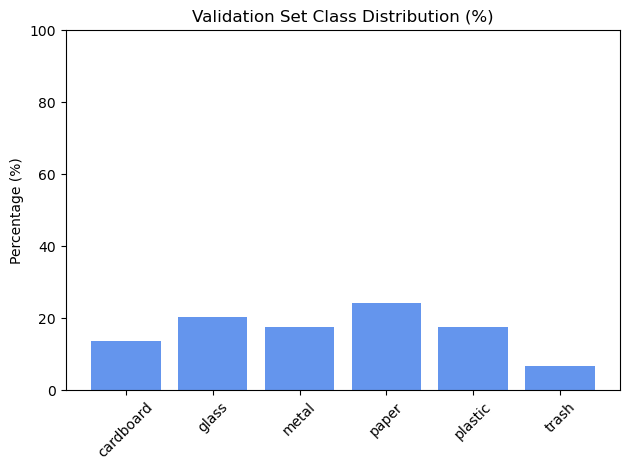

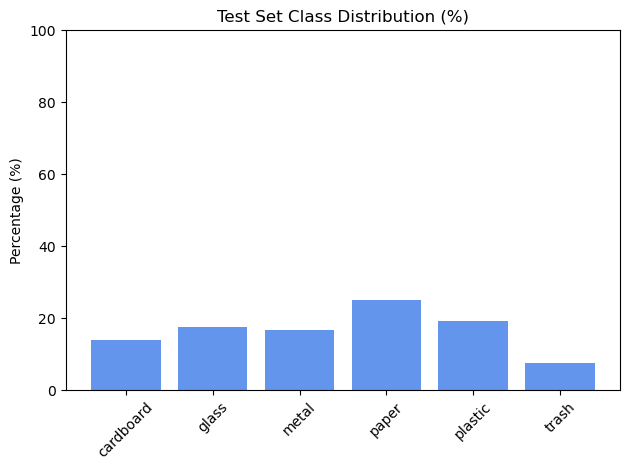

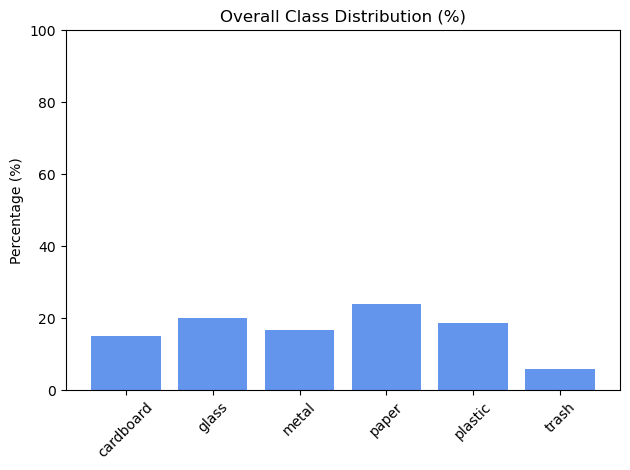

In [23]:
simple_bar_plot(train_dist, "Training Set Class Distribution (%)")
simple_bar_plot(val_dist, "Validation Set Class Distribution (%)")
simple_bar_plot(test_dist, "Test Set Class Distribution (%)")
simple_bar_plot(overall_dist, "Overall Class Distribution (%)")

In [24]:
# Count class occurrences and prepare label list
class_counts = {i: 0 for i in range(len(class_names))}
all_labels = []

for images, labels in train_ds:
    for label in labels.numpy():
        class_counts[label] += 1
        all_labels.append(label)

# Compute class weights (index aligned)
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(class_names)),
    y=all_labels
)

# Create dictionary mapping class index to weight
class_weights = {i: w for i, w in enumerate(class_weights_array)}

In [25]:
print("Class Counts:", class_counts)
print("Class Weights:", class_weights)


Class Counts: {0: 334, 1: 399, 2: 322, 3: 471, 4: 393, 5: 103}
Class Weights: {0: 1.0089820359281436, 1: 0.8446115288220551, 2: 1.046583850931677, 3: 0.7154989384288747, 4: 0.8575063613231552, 5: 3.2718446601941746}


In [26]:
#  Define data augmentation pipeline
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

In [27]:
#  Load the pretrained MobileNetV3Small model (without the top classification layer)
base_model = EfficientNetV2B2(include_top=False, input_shape=(124, 124, 3),include_preprocessing=True, weights='imagenet')


#  Freeze early layers (to retain general pretrained features)
base_model.trainable = True
for layer in base_model.layers[:100]:  # You can adjust this number
    layer.trainable = False


35839040/35839040 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step


In [28]:
#  Build the final model
model = Sequential([
    layers.Input(shape=(124, 124, 3)),
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(6, activation='softmax')  # Change to your number of classes
])


In [29]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [30]:
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',           
    patience=3,                   
    restore_best_weights=True     
)

In [33]:
epochs = 15
history = model.fit(
    train_ds,                
    validation_data=val_ds,  
    epochs=epochs,           
    class_weight=class_weights,  
    batch_size=32,          
    callbacks=[early]   
)

Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - accuracy: 0.2897 - loss: 1.7054 - val_accuracy: 0.6218 - val_loss: 1.1920
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.6435 - loss: 1.1239 - val_accuracy: 0.7604 - val_loss: 0.8044
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.7813 - loss: 0.7279 - val_accuracy: 0.8178 - val_loss: 0.5826
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 232s 3s/step - accuracy: 0.8394 - loss: 0.5073 - val_accuracy: 0.8416 - val_loss: 0.4850
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 225s 4s/step - accuracy: 0.8839 - loss: 0.3695 - val_accuracy: 0.8653 - val_loss: 0.4018
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 253s 3s/step - accuracy: 0.9098 - loss: 0.2782 - val_accuracy: 0.8614 - val_loss: 0.3743
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 214s 3s/step - accuracy: 0.9134 - loss: 0.2395 - val_accuracy: 0.8693 - val_loss: 0.3441
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 854s 13s/step - accuracy: 0.9403 - loss: 0.2066 - val_accuracy: 0.8832 - v

In [36]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 124, 124, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b2 (Functional)  │ (None, 4, 4, 1408)     │     8,769,374 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         8,454 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,727,114 (94.33 MB)

 Trainable params: 7,974,642 (30.42 MB)

 Non-trainable params: 803,186 (3.06 MB)

 Optimizer params: 15,949,286 (60.84 MB)

In [37]:
base_model.summary()

Model: "efficientnetv2-b2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 124, 124,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 124, 124,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 124, 124,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 62, 62,    │        864 │ normalization[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 62, 62,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 62, 62,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 62, 62,    │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 62, 62,    │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 62, 62,    │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 62, 62,    │      2,304 │ block1a_project_… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 62, 62,    │         64 │ block1b_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 62, 62,    │          0 │ block1b_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 62, 62,    │          0 │ block1b_project_… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 62, 62,    │          0 │ block1b_drop[0][… │
│                     │ 16)               │            │ block1a_project_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 31, 31,    │      9,216 │ block1b_add[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 31, 31,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 31, 31,    │          0 │ block2a_expand_b

 Total params: 8,769,374 (33.45 MB)

 Trainable params: 7,966,188 (30.39 MB)

 Non-trainable params: 803,186 (3.06 MB)

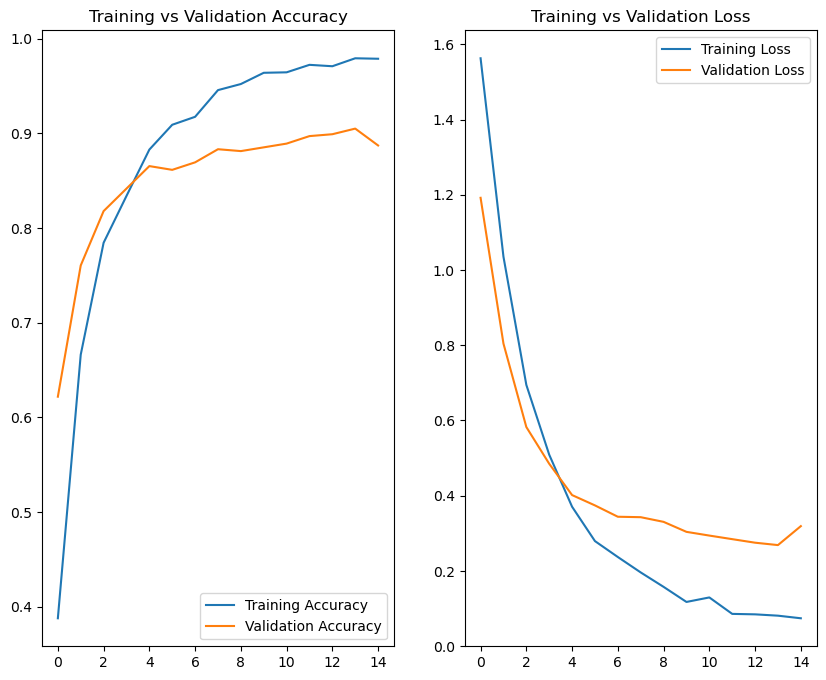

In [42]:
acc = history.history['accuracy']         
val_acc = history.history['val_accuracy']  
loss = history.history['loss']             
val_loss = history.history['val_loss']     
epochs_range = range(len(acc))             
plt.figure(figsize=(10,8))                 
plt.subplot(1,2,1)                        
plt.plot(epochs_range, acc, label='Training Accuracy')      
plt.plot(epochs_range, val_acc, label='Validation Accuracy') 
plt.legend(loc='lower right')              
plt.title('Training vs Validation Accuracy') 
plt.subplot(1,2,2)                         
plt.plot(epochs_range, loss, label='Training Loss')      
plt.plot(epochs_range, val_loss, label='Validation Loss')   
plt.legend(loc='upper right')              
plt.title('Training vs Validation Loss')  
plt.show() 

In [39]:
loss, accuracy = model.evaluate(test_ds_eval)
print(f'Test accuracy is{accuracy:.4f}, Test loss is {loss:.4f}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 332ms/step - accuracy: 0.9022 - loss: 0.2634
Test accuracy is0.9023, Test loss is 0.2689


In [40]:
y_true = np.concatenate([y.numpy() for x, y in test_ds_eval], axis=0)  
y_pred_probs = model.predict(test_ds_eval) 
y_pred = np.argmax(y_pred_probs, axis=1)  
cm = confusion_matrix(y_true, y_pred) 
print(cm)  
print(classification_report(y_true, y_pred))

8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step
[[29  0  0  3  0  0]
 [ 0 52  4  0  4  0]
 [ 0  0 39  0  0  1]
 [ 3  0  0 57  1  0]
 [ 0  4  1  0 41  1]
 [ 0  1  1  1  0 13]]
              precision    recall  f1-score   support

           0       0.91      0.91      0.91        32
           1       0.91      0.87      0.89        60
           2       0.87      0.97      0.92        40
           3       0.93      0.93      0.93        61
           4       0.89      0.87      0.88        47
           5       0.87      0.81      0.84        16

    accuracy                           0.90       256
   macro avg       0.90      0.89      0.89       256
weighted avg       0.90      0.90      0.90       256



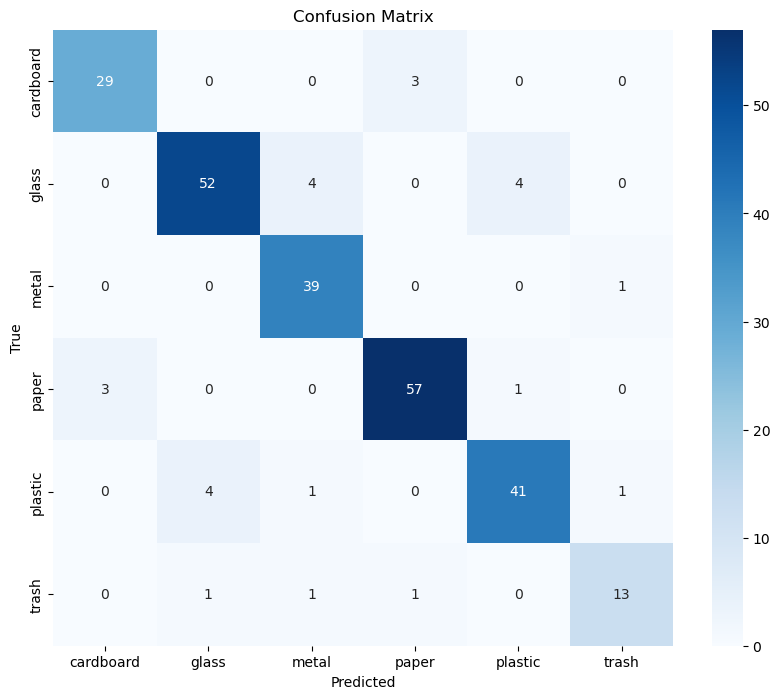

In [41]:
plt.figure(figsize=(10,8))  
sns.heatmap(cm, annot=True, fmt='d', 
            xticklabels=class_names, 
            yticklabels=class_names,  
            cmap='Blues')  
plt.xlabel('Predicted') 
plt.ylabel('True') 
plt.title('Confusion Matrix')  
plt.show() 

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


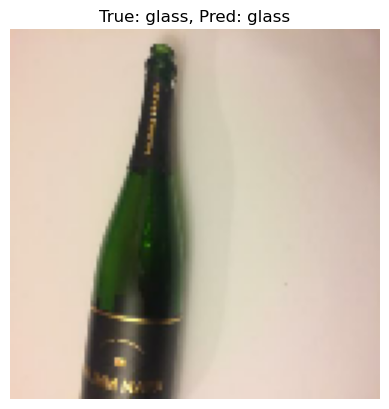

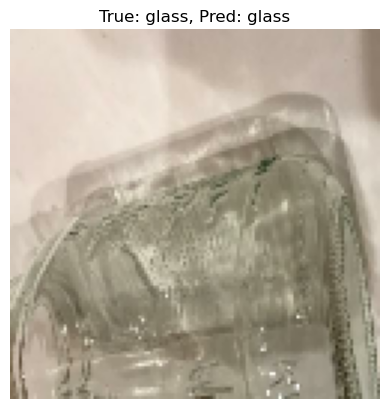

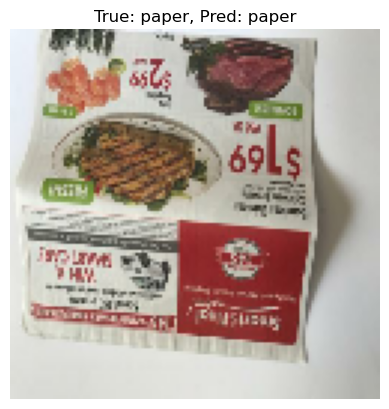

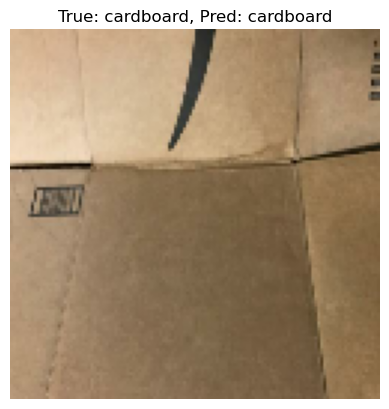

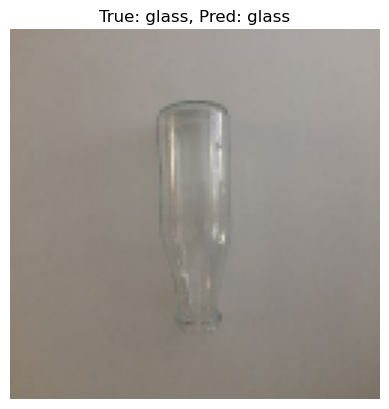

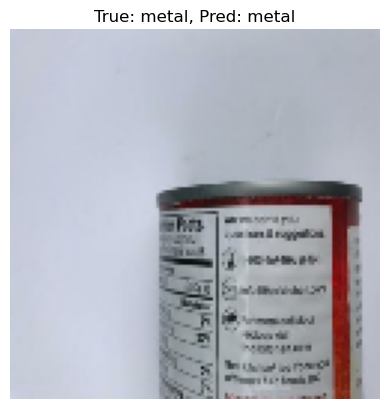

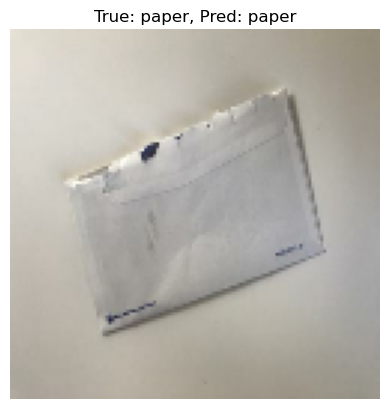

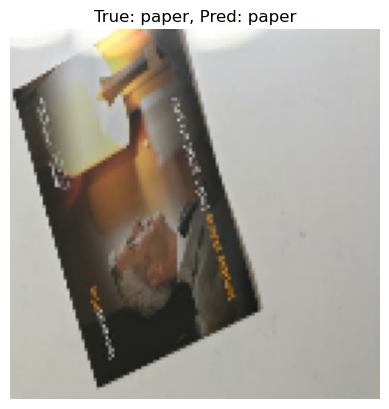

In [43]:
class_names = train_ds.class_names  
for images, labels in test_ds_eval.take(1):  
    predictions = model.predict(images)  
    pred_labels = tf.argmax(predictions, axis=1)  
    for i in range(8):  
        plt.imshow(images[i].numpy().astype("uint8"))  
        plt.title(f"True: {class_names[labels[i]]}, Pred: {class_names[pred_labels[i]]}") 
        plt.axis("off") 
        plt.show() 

In [44]:
model.save('Effiicientnetv2b2.keras')
model = tf.keras.models.load_model('Effiicientnetv2b2.keras')

In [45]:
!pip install gradio

In [46]:
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

In [47]:
def classify_image(img):  
    img = img.resize((124, 124))  
    img_array = np.array(img, dtype=np.float32)  
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)  
    prediction = model.predict(img_array)  
    predicted_class_index = np.argmax(prediction)  
    predicted_class_name = class_names[predicted_class_index]  
    confidence = prediction[0][predicted_class_index]  
    return f"Predicted: {predicted_class_name} (Confidence: {confidence:.2f})" 

In [50]:
iface = gr.Interface(  
    fn=classify_image,   
    inputs=gr.Image(type="pil"),  
    outputs="text"  
)  
iface.launch(share=True) 

* Running on local URL:  http://127.0.0.1:7862

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.
